In [124]:
import pandas as pd
import os
import geopandas as gpd
import numpy as np

In [125]:
dir_path = '../../tfg/data/15995_4699_2024-10-31_12-16-30'
#dir_path = '../../tfg/data/15994_4699_2024-10-31_11-54-16'
stations_meta = pd.read_excel('../../tfg/data/Stationsliste_HydrowebSAM_EN_july2023.xlsx',skiprows=range(0,4))
stations_meta.rename(columns={'Station number': 'Stationsnummer'}, inplace=True)
stations_meta.drop_duplicates(subset = ['Stationsnummer'], inplace=True)

In [126]:
new_df = pd.DataFrame()
for file in os.listdir(dir_path):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(dir_path, file), delimiter=';', encoding='latin1', skiprows=range(0,8))
        st_number = df.Stationsnummer.unique()
        st_number_str = st_number[0]
        
        if len(st_number) > 1:
            i = 1
            while st_number_str == 'Stationsnummer' or np.isnan(float(st_number_str)):
                st_number = st_number[i]
                i+=1
            print('More than one station number')
        print(st_number_str)
        if st_number_str in stations_meta['Stationsnummer'].values:
            print('Station number found')
            new_df = pd.concat([new_df,stations_meta[stations_meta['Stationsnummer']==st_number_str]])
            

2606
Station number found
2457
Station number found
2462
Station number found
2288
Station number found
2034
Station number found
2356
Station number found
2493
Station number found
2604
Station number found
2414
Station number found
2084
Station number found
2130
Station number found
2392
Station number found
2044
Station number found
2030
Station number found
2410
Station number found
2256
Station number found
2019
Station number found
2635
Station number found
2205
Station number found
2113
Station number found
2126
Station number found
2369
Station number found
2282
Station number found
2167
Station number found
2179
Station number found
2485
Station number found
2152
Station number found
2612
Station number found
2375
Station number found
2232
Station number found
2386
Station number found
2056
Station number found
2009
Station number found
2150
Station number found
2608
Station number found
2307
Station number found
2011
Station number found
2500
Station number found
2623
Station

In [127]:
new_df

,Operating status,River basin,Stationsnummer,Water body,Station name,Water body type,X-Coordinate,Y-Coordinate,Station altitude [m a.s.l.],Catchment size [km2],Mean catchment altitude [m a.s.l.],Glacial area [%],Measured parameter,Data available from,Data available until
964,in operation,Rhone,2606,Rhône,"Genève, Halle de l'île",River,2499890,1117850.0,373,8000.0,1658.0,7.2,Discharge,1919-01-01,today
852,in operation,Aare,2457,Aare,"Ringgenberg, Goldswil",River,2633731,1171508.0,564,1138.0,1951.0,12.1,Water level,1980-01-01,today
863,in operation,Inn,2462,Inn,S-Chanf,River,2795792,1165907.0,1648,616.0,2463.0,6.1,pH value,1999-03-25,today
551,in operation,Rhine,2288,Rhein,"Neuhausen, Flurlingerbrücke",River,2689140,1281987.0,388,11930.0,1239.0,0.3,Discharge,1904-01-01,today
97,in operation,Aare,2034,Broye,"Payerne, Caserne d'aviation",River,2561671,1187319.0,446,416.0,715.0,0.0,Water temperature,1976-01-01,today
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,in operation,Etschgebiet,2617,Rom,Müstair,River,2830800,1168706.0,1236,128.0,2184.0,0.0,Water level,1994-05-19,today
971,in operation,Limmat,2609,Alp,Einsiedeln,River,2698640,1223035.0,845,46.7,1157.0,0.0,Discharge,1991-02-27,today
889,in operation,Rhine,2473,Rhein,"Diepoldsau, Rietbrücke",River,2766305,1250371.0,412,6299.0,1771.0,0.6,pH value,1976-01-01,today
533,in operation,Reuss,2276,Grosstalbach,Isenthal,River,2685505,1196051.0,765,43.9,1819.0,6.7,Water temperature,2004-02-19,today


In [128]:
crs_original = "EPSG:2056"  # o usa "EPSG:21781" si las coordenadas están en LV03

# Convertir el DataFrame de pandas a un GeoDataFrame de geopandas
gdf = gpd.GeoDataFrame(
    new_df,
    geometry=gpd.points_from_xy(new_df["X-Coordinate"], new_df["Y-Coordinate"]),
    crs=crs_original
)

# Proyectar al CRS deseado, por ejemplo WGS84 (EPSG:4326)
gdf = gdf.to_crs("EPSG:4326")


<Axes: >

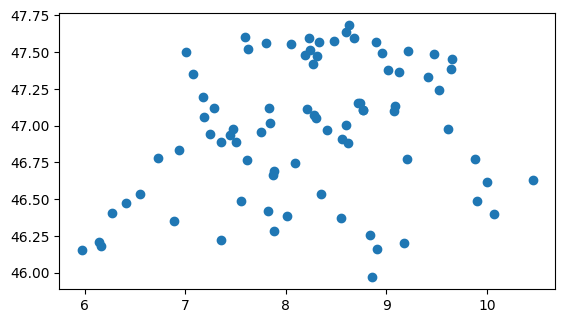

In [129]:
gdf.plot()

In [131]:
df

,Stationsname,Stationsnummer,Parameter,Zeitreihe,Parametereinheit,Gewässer,Zeitstempel,Zeitpunkt_des_Auftretens,Wert,Freigabestatus
0,"Baden, Limmatpromenade",2243,Wassertemperatur,Monatsmittel,°C,Limmat,2013-01-01 00:00:00,NaN,5.53,"Freigegeben, validierte Daten"
1,"Baden, Limmatpromenade",2243,Wassertemperatur,Monatsmittel,°C,Limmat,2013-02-01 00:00:00,NaN,4.57,"Freigegeben, validierte Daten"
2,"Baden, Limmatpromenade",2243,Wassertemperatur,Monatsmittel,°C,Limmat,2013-03-01 00:00:00,NaN,5.04,"Freigegeben, validierte Daten"
3,"Baden, Limmatpromenade",2243,Wassertemperatur,Monatsmittel,°C,Limmat,2013-04-01 00:00:00,NaN,7.25,"Freigegeben, validierte Daten"
4,"Baden, Limmatpromenade",2243,Wassertemperatur,Monatsmittel,°C,Limmat,2013-05-01 00:00:00,NaN,11.22,"Freigegeben, validierte Daten"
...,...,...,...,...,...,...,...,...,...,...
136,"Baden, Limmatpromenade",2243,Wassertemperatur,Monatsmittel,°C,Limmat,2024-05-01 00:00:00,NaN,14.21,"Freigegeben, geprüfte Daten"
137,"Baden, Limmatpromenade",2243,Wassertemperatur,Monatsmittel,°C,Limmat,2024-06-01 00:00:00,NaN,17.52,"Freigegeben, geprüfte Daten"
138,"Baden, Limmatpromenade",2243,Wassertemperatur,Monatsmittel,°C,Limmat,2024-07-01 00:00:00,NaN,21.12,"Freigegeben, geprüfte Daten"
139,"Baden, Limmatpromenade",2243,Wassertemperatur,Monatsmittel,°C,Limmat,2024-08-01 00:00:00,NaN,24.25,"Freigegeben, geprüfte Daten"


In [132]:
stations_meta

,Operating status,River basin,Stationsnummer,Water body,Station name,Water body type,X-Coordinate,Y-Coordinate,Station altitude [m a.s.l.],Catchment size [km2],Mean catchment altitude [m a.s.l.],Glacial area [%],Measured parameter,Data available from,Data available until
0,out of operation,Aare,58,Aare,"Unterseen, Gurben",River,2631170,1170070.0,559,1140.0,NaN,NaN,Discharge,1925-07-24,1979-12-31
1,out of operation,Aare,60,Areuse,Champ du Moulin,River,2547820,1200110.0,635,359.0,NaN,NaN,Discharge,1904-01-01,1985-12-31
2,in operation,Aare,70,Emme,Emmenmatt,River,2623616,1200426.0,641,443.0,1065.0,0.0,Discharge,1909-01-01,today
3,in operation,Adda,78,Poschiavino,Le Prese,River,2803501,1130509.0,969,168.0,2162.0,4.0,Discharge,1931-01-01,today
4,in operation,Aare,155,Emme,"Wiler, Limpachmündung",River,2608228,1223238.0,459,937.0,858.0,0.0,Discharge,1921-07-01,today
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,out of operation,Inn,8132,Spöl,Zernez,River,2803630,1175110.0,1481,NaN,NaN,NaN,Discharge,1914-01-01,1933-12-31
1249,out of operation,Rhine,8141,Birse,"Soyhières, Hasenburg",River,2596480,1248980.0,395,590.0,NaN,NaN,Discharge,1982-06-26,1985-12-31
1251,out of operation,Rhone,8168,Rhône,Peney,River,2492300,1117000.0,357,10137.0,NaN,NaN,Discharge,1904-01-01,1942-12-31
1252,out of operation,Adda,8169,Albigna,Alpe Albigna,River,2770050,1134300.0,2040,21.0,NaN,NaN,Discharge,1932-01-01,1955-12-31


In [130]:
len(gdf)

81